## Lesson 06: Unsupervised Learning - Clustering

## K-Means Clustering - Cluster Visualization

#### Clustering Mini Project 

In this project, we’ll apply [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) (a variant of [Lloyd's Algorithm](https://en.wikipedia.org/wiki/Lloyd's_algorithm) or Voronoi Iteration) to the Enron financial dataset available in the [ud120-projects repo](https://www.github.com/udacity/ud120-projects). For your convenience, I have included the data file in this repository. We're also going to define a function `DrawClusters()` that will allow us to visualize the resulting clusters. 

Our final goal, of course, is to identify persons of interest; since we have labeled data, this is not a question that particularly calls for an unsupervised approach like k-means clustering. Nonetheless, it is interesting to attempt a clustering analysis to see how well this kind of approach can distinguish between poi's and non-poi's. You’ll also get some hands-on practice with k-means in this project, and play around with feature scaling.

### 0 | Preliminaries 
As usual, we start by loading the packages we are going to use. These should be already by installed in your environment. There are no new packages that need to be installed for this session

 - numpy
 - pandas
 - sklearn
 - matplotlib
 
In addition, we will be using data and some code from the ud120-projects repo, so those should be available on your local machine as well
 
 Run the cell below to load them

In [1]:
#!/usr/bin/python 

import pickle

try:
    import numpy as np
    print("Successfully imported numpy! (Version {})".format(np.version.version))
except ImportError:
    pass
    
try:
    import matplotlib
    import matplotlib.pyplot as plt
    print("Successfully imported matplotlib! (Version {})".format(matplotlib.__version__))
except ImportError:
    pass

try:
    import pandas as pd
    print("Successfully imported pandas! (Version {})".format(pd.__version__))
    pd.options.display.max_rows = 10
except ImportError:
    print("Could not import pandas!")

import os, sys

try:
    from IPython.display import display
    from IPython.display import Image
    print("Successfully imported display and Image from IPython.display!")
except ImportError:
    print("Could not import from IPython.display")

%matplotlib inline

Successfully imported numpy! (Version 1.13.1)
Successfully imported matplotlib! (Version 2.0.2)
Successfully imported pandas! (Version 0.20.3)
Successfully imported display and Image from IPython.display!


### 1 | Load the Dataset

**Run** the next two cells to load he dataset and define some helper functions

In [2]:
## TODO - adjust the value of the PATH_TO_MINI variable so it points to the top level folder of the Udacity projects
##     For example, here is the structure on my machine:
###         parent dir (projects)
###               -  ZKConnect (folder for ConnectIntensive notebooks
###                     - lesson-06-part-01,ipynb (this file)
###               -  projects  (root folder for all Udacity projects - github ud120) 
###                     - final_project
###                     - k_means
###                     - naive_bayes
###                     - tools
###
### So, I would set PATH_TO_MINI = '../projects'
###
### Once this is correctly set using either a relative path or an absolute path, the rest of the code should work correctly

PATH_TO_MINI = "./data"

### Once you have the path set, the output from this cell should say so

try:
    path_ok = os.path.isfile(os.path.join(PATH_TO_MINI,"clustering","final_project_dataset.pkl"))
    if not path_ok:
        raise Exception("Path is not set correctly")
    print "PATH_TO_MINI appears correct (can open project data file)" 
except Exception as e:
    print e
    

PATH_TO_MINI appears correct (can open project data file)


The cell below defines the `DrawClusters()` function adapated from  [the `Draw()` function from `"ud120-projects/kmeans/k_means_cluster.py"`](https://github.com/udacity/ud120-projects/blob/master/k_means/k_means_cluster.py). Here's a quick summary of changes:
  - `DrawClusters()` works with the `pandas` `DataFrame` object `enron_df`.
  - Some of the functionality from `"ud120-projects/tools/feature_format.py"` is incorporated into `DrawClusters()`:
    - The ability to remove instances with **all** zeroes from k-means clustering
    - The ability to remove instances with **any** zeroes from k-means clustering
    - The ability to rescale features, remapping them to the interval [0,1]
  - `DrawClusters()` also draws the resulting decision boundary when `feature_list` contains only two features.
  
**Read** through the code for `DrawClusters` to see how `KMeans` is used within the function to compute and display the cluster centers

In [3]:
sys.path.append(PATH_TO_MINI)
sys.path.append(os.path.join("./tools"))
sys.path.append(os.path.join("./k_means"))

## Adapted from ud120-projects/k_means/k_means_cluster.py
from feature_format import featureFormat, targetFeatureSplit


from sklearn.cluster import KMeans

def DrawClusters(n_clusters = 2,\
                 feature_list = ["salary","exercised_stock_options"],\
                 remove_any_zeroes = False,\
                 remove_all_zeroes = True,\
                 rescale_features = False,\
                 x_label = 'Salary',\
                 y_label = 'Exercised Stock Options'):
    
    '''
    Plots k-means clusters trained on a list of features from enron_df
    @param n_clusters:        an integer, the number of clusters to form.
    @param feature_list:      a list of strings, the features to use in KMeans clustering
                              (first two features in the list will be plotted on x,y axes)
                              if len(feature_list) == 2, decision boundaries will be plotted 
    @param remove_any_zeroes: a boolean, whether or not to remove points when clustering
                              that contain ANY zeroes
    @param remove_all_zeroes: a boolean, whether or not to remove points when clustering
                              that contain ONLY zeroes
    @param rescale_features:  a boolean, whether or not to rescale features from 0 to 1
    @param kmns:              (optional) KMeans cluster model. If provided, ignores 
    @param x_label:           a string, the x-axis label of the plot
    @param y_label:           a string, the y-axis label of the plot
    '''

    # Initialize color and shape lists for scatterplot
    # Note: need to lengthen the color and shape lists if
    #       you want to use more than 7 clusters.
    color_list = ["r","g","b","c","m","y","k"]
    shape_list = ["^","o","s","v","D","<","h"]
    
    # Initialize figure and axes:
    fig, ax = plt.subplots()

    # We are going to cluster the data using KMeans,
    # based on the features from the parameter feature_list.
    X = enron_df[feature_list]
    
    # We can see if clustering correctly identified POIs
    y = enron_df['poi']
    
    # If desired, remove instances where ANY feature is zero
    if remove_any_zeroes:
        X = X[~(X.T == 0).any()]
        
    # If desired, remove instances where ALL features are zeroes
    if remove_all_zeroes:
        X = X[~(X.T == 0).all()]

    # If desired, rescale features
    if rescale_features:
        for feature in X.columns:
            min_feature = X[~(X[feature] == 0)][feature].min()
            max_feature = X[~(X[feature] == 0)][feature].max()
            range_feature = max_feature - min_feature
            X[feature] = (X[feature] - min_feature)*1.0 / range_feature
            
    # If we removed any instances above, we need to keep 
    # only the corresponding instances in y (the POI Series)
    y = y.loc[X.index]
    
    # By default, the first two features in the list are chosen
    # as the x and y features.
    x_feature = feature_list[0]
    y_feature = feature_list[1]

    # Determine the min & max values of x_feature, compute the range,
    # and pad the minimum and maximum x values by 5% of the range
    x_min, x_max = X[x_feature].min(), X[x_feature].max()
    x_range = x_max - x_min
    x_min -= x_range * 0.05
    x_max += x_range * 0.05
    
    # Determine the min & max values of y_feature, compute the range,
    # and pad the minimum and maximum y values by 5% of the range
    y_min, y_max = X[y_feature].min(), X[y_feature].max()
    y_range = y_max - y_min
    y_min -= y_range * 0.05
    y_max += y_range * 0.05
    
    # Compute k-means clustering.
    kmns = KMeans(n_clusters = n_clusters).fit(X)

    
    # We can visualize the decision boundaries if the 
    # k-means clusters are formed from just two features
    if len(feature_list) == 2:
        # Return coordinate matrices xx and yy from arrays
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, num = 500),\
                             np.linspace(y_min, y_max, num = 500))

        # Use the clustering to make a prediction for each point
        # in the coordinate matrices, then reshape for plotting.
        Z = kmns.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot semitransparent filled contours for the
        # cluster decision boundaries
        ax.contourf(xx, yy, Z,\
                    levels=list(np.arange(n_clusters+1)-0.5),\
                    colors=tuple(color_list[:n_clusters]),alpha=0.2)
    
    # Scatterplot all of the points in each cluster,
    # with each cluster a different color and shape
    pred = kmns.predict(X)
    for cluster_idx in range(n_clusters):
        X_cluster = X[pred == cluster_idx]
        ax.scatter(X_cluster[x_feature], X_cluster[y_feature],\
                   s=30, marker = shape_list[cluster_idx],\
                   edgecolor='k', facecolor=color_list[cluster_idx], alpha=0.8)
        
    # Denote the centroids of each cluster with a white X
    centers = kmns.cluster_centers_
    if len(feature_list) == 2:
        for center in centers:
            ax.scatter(center[0],center[1],marker='x',facecolor="w",linewidth=3,s=50)
            
    # Set the title and axes labels, and adjust the aspect ratio for rescaled data
    if rescale_features:
        title   = ax.set_title("K Means - {} Clusters (Rescaled)".format(n_clusters))
        # Force the axes aspect ratio to be plotted equally
        ax.set(adjustable='box-forced', aspect='equal')
    else:
        title   = ax.set_title("K Means - {} Clusters".format(n_clusters))
    x_label = ax.set_xlabel(x_label)
    y_label = ax.set_ylabel(y_label)
    
    # Set the x- and y-axis limits using the padded minimum and maximum values
    xlim = ax.set_xlim((x_min,x_max))
    ylim = ax.set_ylim((y_min,y_max))
    
print("DrawClusters() is ready to use!")

DrawClusters() is ready to use!


In [4]:
### load in the dict of dicts containing all the data on each person in the dataset

enron_data = pickle.load( open(os.path.join(PATH_TO_MINI,"clustering","final_project_dataset.pkl"), "r"))
print "Loaded dataset - has {} keys (or rows)".format( len(enron_data.keys()) )

Loaded dataset - has 146 keys (or rows)


### 2 | Data Exploration and pre-processing

We want to get a sense of what is in the data set, whether there are any missing values that need to be cleaned up. 

We couldn't find *all* the details for each person involved with the Enron scandal, so the Enron data set has some missing values denoted by `"NaN"` entries in the data dictionary. Because we must pass numeric arrays into `sklearn` modules, we need to preprocess the data dictionary a bit before we can use [`sklearn.cluster.KMeans()`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

##### Question 1 - How many different persons are there in this dataset? Are there any keys that should be excluded? (HINT: There is at least one). 

In [5]:
## The preliminary structure we loaded is a python dictionary whose keys are the names of people at Enron.
## print the list os keys to see all the names. Scroll through the names to see if you can identify one obvious key 
## that should be removed (it is not a person's name)
display(enron_data.keys())

['METTS MARK',
 'BAXTER JOHN C',
 'ELLIOTT STEVEN',
 'CORDES WILLIAM R',
 'HANNON KEVIN P',
 'MORDAUNT KRISTINA M',
 'MEYER ROCKFORD G',
 'MCMAHON JEFFREY',
 'HORTON STANLEY C',
 'PIPER GREGORY F',
 'HUMPHREY GENE E',
 'UMANOFF ADAM S',
 'BLACHMAN JEREMY M',
 'SUNDE MARTIN',
 'GIBBS DANA R',
 'LOWRY CHARLES P',
 'COLWELL WESLEY',
 'MULLER MARK S',
 'JACKSON CHARLENE R',
 'WESTFAHL RICHARD K',
 'WALTERS GARETH W',
 'WALLS JR ROBERT H',
 'KITCHEN LOUISE',
 'CHAN RONNIE',
 'BELFER ROBERT',
 'SHANKMAN JEFFREY A',
 'WODRASKA JOHN',
 'BERGSIEKER RICHARD P',
 'URQUHART JOHN A',
 'BIBI PHILIPPE A',
 'RIEKER PAULA H',
 'WHALEY DAVID A',
 'BECK SALLY W',
 'HAUG DAVID L',
 'ECHOLS JOHN B',
 'MENDELSOHN JOHN',
 'HICKERSON GARY J',
 'CLINE KENNETH W',
 'LEWIS RICHARD',
 'HAYES ROBERT E',
 'MCCARTY DANNY J',
 'KOPPER MICHAEL J',
 'LEFF DANIEL P',
 'LAVORATO JOHN J',
 'BERBERIAN DAVID',
 'DETMERING TIMOTHY J',
 'WAKEHAM JOHN',
 'POWERS WILLIAM',
 'GOLD JOSEPH',
 'BANNANTINE JAMES M',
 'DUNCAN JOHN H'

Add appropriate code in the cell below to complete our preprocessing steps:
  - Remove the outlier: the bad entry is `"TOTAL"` in the data dictionary containing totals of all features.
  - Create a pandas `DataFrame` object from the Enron data dictionary
  - Take the **transpose** of the Enron `DataFrame` with [`DataFrame.T`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.T.html), so that rows correspond to individuals (instances). 
  - Impute missing values: Replace all "NaN" values in the DataFrame with **zeroes**.

In [6]:
# Preprocessing the Enron dataset:
# there's an outlier--remove it! 
enron_data.pop("TOTAL", 0) # TO DO

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}



As we've seen before, `pandas` dataframes provide a convenient way of managing data. We will use the `from_dict` method of a DataFrame object to load our python data_dict. However, when the dictionary object loaded, the resulting DataFrame has the list of keys as its columns. We can "flip" this using the transpose (.T) so that each row contains the data for one person.

In [7]:
# Create a DataFrame object from the Enron data dictionary
enron_df = pd.DataFrame.from_dict(enron_data) # TO DO 

# Take the transpose (.T) of the Enron DataFrame,
# so that rows of the DataFrame correspond to individuals
enron_df = enron_df.T #TO DO

# Display the DataFrame to get a sense of the data
display(enron_df)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WINOKUR JR. HERBERT S,NaN,NaN,-25000,108579,NaN,NaN,1413,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,84992,NaN
WODRASKA JOHN,NaN,NaN,NaN,NaN,john.wodraska@enron.com,NaN,NaN,NaN,NaN,NaN,...,NaN,189583,False,NaN,NaN,NaN,NaN,NaN,189583,NaN
WROBEL BRUCE,NaN,NaN,NaN,NaN,NaN,139130,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,139130
YEAGER F SCOTT,NaN,NaN,NaN,NaN,scott.yeager@enron.com,8308552,53947,NaN,NaN,NaN,...,NaN,147950,True,3576206,NaN,158403,NaN,NaN,360300,11884758


As you can see, several of the features have missing values and we will need to get rid of them using imputation.

In [8]:
# Change all entries in the DataFrame with "NaN" to zeroes.
enron_df[enron_df == "NaN"] = 0

#### Question 2 - Why is it ok to replace the missing values with 0? Write your thoughts in the cell below and we will discuss as a group. Think about the other ways you can impute missing data, e.g., mean or median values.

**Answer:** We really should consider how the imputation is going to affect our subsequent analysis before we fill in values that were missing. Some of the considerations would be how are we impacting the statistics of each feature, i.e., averages, standard deviations (more generally distributions). In some cases, it may more sense to simply drop the rows. In this exercise, since we are planning to do cluster analysis, the value we set to zero may end up being clustered by themselves along some axis (e.g., salary) hich we would know might contain imputed data. This would be easier to identify than if we used the median or mean values.

Run the cell below to create a scatterplot of the data with two features, then look at the resulting figure. What clusters you would expect to arise from this data if 2 clusters are created? Try different pairs of features and select three features. We will use them for creating clusters using the K-means algorithm later.

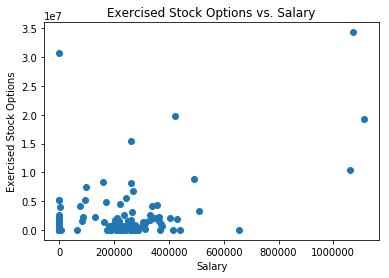

In [9]:
fig, ax = plt.subplots()
ax.scatter(enron_df["salary"],enron_df["exercised_stock_options"])
title   = ax.set_title("Exercised Stock Options vs. Salary")
xlabel  = ax.set_xlabel("Salary")
ylabel  = ax.set_ylabel("Exercised Stock Options")

** Question 3** - What are the features (i.e., columns or variables) available in this dataset? Which ones might be useful for identifying a `person of interest` (_poi_)? Please write down three choices

**Answer:** `salary`, `exercised_stock_options`, `from_poi_to_this_person`, `from_this_person_to_poi`

### Deploying Clustering
Let's perform k-means clustering on the data using only two of the features you identified above. Enter them as the values of the variables `feature_1` and `feature_2`. The online quiz specifies which features to use  ("salary", "exercised_stock_options"), but try experimenting with other combinations 

In [10]:
# TODO
feature_1 = "salary"
feature_2 = "exercised_stock_options"

#### Clustering with two features

**Run** the cell below to generate and visualize the results of `Kmeans` clustering with 2 clusters

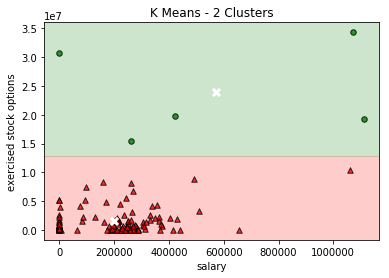

In [11]:
DrawClusters(n_clusters = 2,\
             feature_list = [feature_1, feature_2],\
             remove_any_zeroes = False,\
             remove_all_zeroes = True,\
             rescale_features = False,\
             x_label = feature_1.replace("_", " "),\
             y_label = feature_2.replace("_", " "))

** In the scatterplot that pops up, are the clusters what you expected? ** (_All answers are correct!_)

**Answer:** (_All answers are correct. These are just my observations_) The two cluster model looks too simplistic. It appears to be based on just one feature -- `exercised_stock_options`

#### Three features clustering

In this section add a third feature and rerun the clustering. The online quiz specifies which feature to use  ("total payments"), but feel free to experiment with others. 

You can copy and modify the cells from the two features groups above to complete this.

In [13]:
# TODO
feature_1 = "salary"
feature_2 = "exercised_stock_options"
feature_3 = "total_payments"

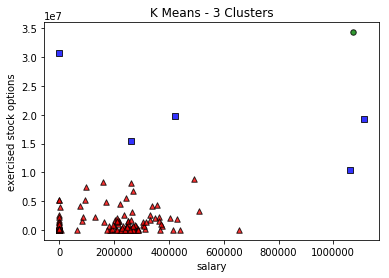

In [17]:
#TODO
DrawClusters(n_clusters = 3,\
             feature_list = [feature_1, feature_2, feature_3],\
             remove_any_zeroes = False,\
             remove_all_zeroes = True,\
             rescale_features = False,\
             x_label = feature_1.replace("_", " "),\
             y_label = feature_2.replace("_", " "))

#### Question 4 - Compare the plot with the clusterings to the one you obtained with 2 input features. Do any points switch clusters? How many? This new clustering, using 3 features, couldn’t have been guessed by eye--it was the k-means algorithm that identified it.

**Answer:** Yes, two points (near the right edge of the figure) switched clusters

#### Feature Scaling 

As you can see, if you attempted to use one of the finance features as a variable, most of the "points" are close together but there are several that are fairly far away from the rest. Feature scaling is way to "normalize" the data so we don't end up emphasizing any one dimension too much.

The next few questions (aligned with the online mini-project quizzes) lead you through some of the calculations that are done for feature scaling.


(NB: if you look at finance_features, there are some "NaN" values that have been cleaned away and replaced with zeroes--so while those might look like the minima, it's a bit deceptive because they're more like points for which we don't have information, and just have to put in a number. So for this question, we will go back to unmodified data and look for the maximum and minimum numbers that show up there, ignoring all the "NaN" entries). To help with this task, run the cell below to create the data frame df from the enron_data dictionary.


In [21]:
# Create a new DataFrame object from original the Enron data dictionary
df = pd.DataFrame.from_dict(enron_data)

# Take the transpose (.T) of the Enron DataFrame,
# so that rows of the DataFrame correspond to individuals
df = df.T

print("DataFrame df has been created!")

DataFrame df has been created!


** What are the maximum and minimum values taken by the “exercised_stock_options” feature used in this example? **

In [43]:
column = "exercised_stock_options"
print("The maximum and minimum values of exercised_stock_options are {} and {}.".\
      format(df[~(df[column]=="NaN")][column].max(),\
             df[~(df[column]=="NaN")][column].min()))


The maximum and minimum values of exercised_stock_options are 34348384 and 3285.


#### What are the maximum and minimum values taken by “salary”?

This feature also had NaNs in the original data

In [42]:
column = "salary"
print("The maximum and minimum values of exercised_stock_options are {} and {}.".\
      format(df[~(df[column]=="NaN")][column].max(),\
             df[~(df[column]=="NaN")][column].min()))


The maximum and minimum values of exercised_stock_options are 1111258 and 477.


### Clustering Changes with Feature Scaling

**Run** the cell below to do simple feature rescaling, mapping the original ranges of two features onto the interval [0,1]. You should find that some of the points change clusters! You should also find that these clusters are not as stable as in the previous examples. Run the cell multiple times. You should find that the reported clusters are sometimes different, depending on where the centroids were initialized for k-means.

In [ ]:
DrawClusters(n_clusters = 2,\
             feature_list = [feature_1, feature_2],\
             remove_any_zeroes = False,\
             remove_all_zeroes = True,\
             rescale_features = True,\                     # This has been set to true to do the scaling
             x_label = feature_1.replace("_", " "),\
             y_label = feature_2.replace("_", " "))

** Compare this result with the output for the two clusters without scaling. What do you notice?